# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [229]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

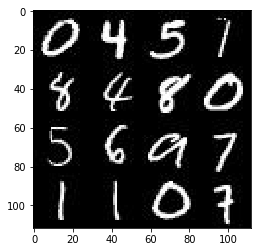

In [230]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

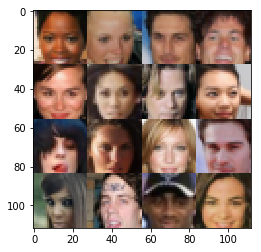

In [231]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [232]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [233]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    input_real_ph = tf.placeholder(
        tf.float32,
        [None, image_width, image_height, image_channels],
        name='input_real')
    
    input_z_ph = tf.placeholder(
        tf.float32,
        [None, z_dim],
        name='input_z')
    
    learning_rate_ph = tf.placeholder(
        tf.float32,
        [],
        name='learning_rate')

    return input_real_ph, input_z_ph, learning_rate_ph


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [234]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        
        # Convolution
        input_image = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        input_image = tf.maximum(alpha * input_image, input_image)
        # 14x14x32 now
        
        # Convolution
        conv1 = tf.layers.conv2d(input_image, 64, 5, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 7x7x64 now
        
        # Flatten
        flat = tf.reshape(conv1, (-1, 7*7*64))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [235]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):

        # Fully Conn
        dense = tf.layers.dense(z, 7*7*64)
        
        # Reshape
        reshape = tf.reshape(dense, (-1, 7, 7, 64))
        # 7x7x64 now
        
        # Convolution
        conv1 = tf.layers.conv2d_transpose(reshape, 32, 5, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x32 now
        
        # Convolution
        logits = tf.layers.conv2d_transpose(conv1, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        output = tf.tanh(logits)
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [236]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [237]:

def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [238]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train.

In [239]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # DONE: Build Model
    _ , img_w, img_h, img_d = data_shape
    real_input, z_input, lr = model_inputs(img_w, img_h, img_d, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, img_d)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    print_every = 10
    show_every = 100
    
    figsize=(5,5)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, img_d, data_image_mode)
                    
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.

Epoch 1/2... Discriminator Loss: 0.7192... Generator Loss: 0.8827
Epoch 1/2... Discriminator Loss: 0.5618... Generator Loss: 1.4684
Epoch 1/2... Discriminator Loss: 0.5475... Generator Loss: 2.5417
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 0.6170
Epoch 1/2... Discriminator Loss: 1.1376... Generator Loss: 0.8219
Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 1.3356
Epoch 1/2... Discriminator Loss: 1.0259... Generator Loss: 0.9004
Epoch 1/2... Discriminator Loss: 0.8520... Generator Loss: 0.8875
Epoch 1/2... Discriminator Loss: 0.9128... Generator Loss: 1.0203
Epoch 1/2... Discriminator Loss: 1.0426... Generator Loss: 0.6200


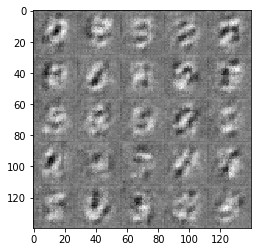

Epoch 1/2... Discriminator Loss: 0.7904... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 0.6987... Generator Loss: 1.1324
Epoch 1/2... Discriminator Loss: 0.5047... Generator Loss: 1.5744
Epoch 1/2... Discriminator Loss: 0.3593... Generator Loss: 2.0583
Epoch 1/2... Discriminator Loss: 0.3289... Generator Loss: 1.6912
Epoch 1/2... Discriminator Loss: 0.2673... Generator Loss: 2.0089
Epoch 1/2... Discriminator Loss: 0.3251... Generator Loss: 1.6180
Epoch 1/2... Discriminator Loss: 0.2976... Generator Loss: 1.6520
Epoch 1/2... Discriminator Loss: 0.3254... Generator Loss: 1.5757
Epoch 1/2... Discriminator Loss: 0.7207... Generator Loss: 0.7280


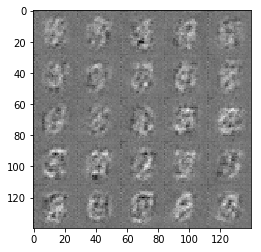

Epoch 1/2... Discriminator Loss: 0.4261... Generator Loss: 1.9726
Epoch 1/2... Discriminator Loss: 0.6738... Generator Loss: 0.8435
Epoch 1/2... Discriminator Loss: 0.8736... Generator Loss: 0.7283
Epoch 1/2... Discriminator Loss: 0.5052... Generator Loss: 1.3602
Epoch 1/2... Discriminator Loss: 0.4251... Generator Loss: 1.6333
Epoch 1/2... Discriminator Loss: 0.4793... Generator Loss: 1.3001
Epoch 1/2... Discriminator Loss: 0.4732... Generator Loss: 1.5226
Epoch 1/2... Discriminator Loss: 0.4125... Generator Loss: 1.7716
Epoch 1/2... Discriminator Loss: 0.9293... Generator Loss: 0.9167
Epoch 1/2... Discriminator Loss: 0.6465... Generator Loss: 0.9453


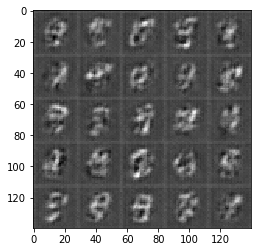

Epoch 1/2... Discriminator Loss: 0.5891... Generator Loss: 1.1755
Epoch 1/2... Discriminator Loss: 0.5264... Generator Loss: 1.5750
Epoch 1/2... Discriminator Loss: 0.5257... Generator Loss: 1.3005
Epoch 1/2... Discriminator Loss: 0.5031... Generator Loss: 1.2861
Epoch 1/2... Discriminator Loss: 0.5541... Generator Loss: 1.2312
Epoch 1/2... Discriminator Loss: 0.5015... Generator Loss: 1.4242
Epoch 1/2... Discriminator Loss: 0.3226... Generator Loss: 1.9879
Epoch 1/2... Discriminator Loss: 0.4951... Generator Loss: 1.3699
Epoch 1/2... Discriminator Loss: 1.4063... Generator Loss: 0.4700
Epoch 1/2... Discriminator Loss: 0.7029... Generator Loss: 1.1171


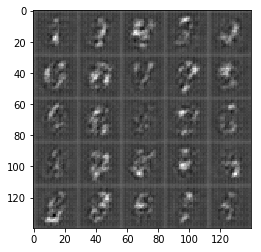

Epoch 1/2... Discriminator Loss: 0.5660... Generator Loss: 1.5565
Epoch 1/2... Discriminator Loss: 0.5973... Generator Loss: 1.0497
Epoch 1/2... Discriminator Loss: 0.4793... Generator Loss: 1.4261
Epoch 1/2... Discriminator Loss: 0.5119... Generator Loss: 1.3108
Epoch 1/2... Discriminator Loss: 0.4259... Generator Loss: 1.5231
Epoch 1/2... Discriminator Loss: 0.3991... Generator Loss: 1.5784
Epoch 1/2... Discriminator Loss: 0.4445... Generator Loss: 1.4689
Epoch 1/2... Discriminator Loss: 0.3715... Generator Loss: 1.7672
Epoch 1/2... Discriminator Loss: 0.2494... Generator Loss: 2.2577
Epoch 1/2... Discriminator Loss: 0.3714... Generator Loss: 1.5592


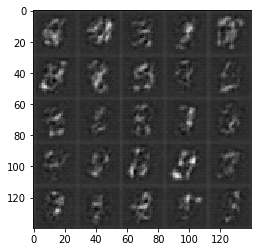

Epoch 1/2... Discriminator Loss: 0.4107... Generator Loss: 1.4740
Epoch 1/2... Discriminator Loss: 0.2329... Generator Loss: 2.2061
Epoch 1/2... Discriminator Loss: 0.2941... Generator Loss: 2.3110
Epoch 1/2... Discriminator Loss: 0.2030... Generator Loss: 2.5555
Epoch 1/2... Discriminator Loss: 0.2170... Generator Loss: 2.8625
Epoch 1/2... Discriminator Loss: 0.4836... Generator Loss: 1.3063
Epoch 1/2... Discriminator Loss: 0.2491... Generator Loss: 2.3177
Epoch 1/2... Discriminator Loss: 0.3459... Generator Loss: 1.6925
Epoch 1/2... Discriminator Loss: 0.2742... Generator Loss: 1.9114
Epoch 1/2... Discriminator Loss: 0.3905... Generator Loss: 1.4052


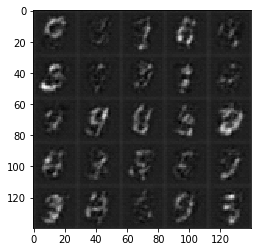

Epoch 1/2... Discriminator Loss: 0.2632... Generator Loss: 2.0526
Epoch 1/2... Discriminator Loss: 1.5971... Generator Loss: 3.2335
Epoch 1/2... Discriminator Loss: 0.4867... Generator Loss: 1.5501
Epoch 1/2... Discriminator Loss: 0.4606... Generator Loss: 2.0811
Epoch 1/2... Discriminator Loss: 0.6794... Generator Loss: 0.9224
Epoch 1/2... Discriminator Loss: 0.4039... Generator Loss: 2.1649
Epoch 1/2... Discriminator Loss: 0.2643... Generator Loss: 2.4654
Epoch 1/2... Discriminator Loss: 0.2389... Generator Loss: 2.0304
Epoch 1/2... Discriminator Loss: 0.3514... Generator Loss: 1.8175
Epoch 1/2... Discriminator Loss: 0.3961... Generator Loss: 1.6684


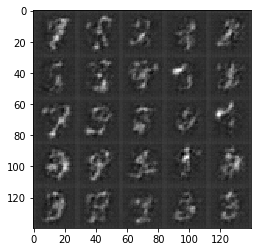

Epoch 1/2... Discriminator Loss: 0.3548... Generator Loss: 1.8664
Epoch 1/2... Discriminator Loss: 0.2362... Generator Loss: 2.1078
Epoch 1/2... Discriminator Loss: 0.2061... Generator Loss: 2.0736
Epoch 1/2... Discriminator Loss: 0.1761... Generator Loss: 2.3484
Epoch 1/2... Discriminator Loss: 0.2371... Generator Loss: 2.3002
Epoch 1/2... Discriminator Loss: 0.1657... Generator Loss: 2.3168
Epoch 1/2... Discriminator Loss: 0.2178... Generator Loss: 2.2563
Epoch 1/2... Discriminator Loss: 0.1834... Generator Loss: 2.2252
Epoch 1/2... Discriminator Loss: 0.2801... Generator Loss: 1.8493
Epoch 1/2... Discriminator Loss: 0.1523... Generator Loss: 2.6550


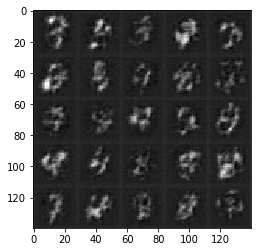

Epoch 1/2... Discriminator Loss: 0.1351... Generator Loss: 2.8096
Epoch 1/2... Discriminator Loss: 0.1944... Generator Loss: 2.5597
Epoch 1/2... Discriminator Loss: 0.2460... Generator Loss: 2.1117
Epoch 1/2... Discriminator Loss: 0.2440... Generator Loss: 2.1383
Epoch 1/2... Discriminator Loss: 0.1384... Generator Loss: 3.2178
Epoch 1/2... Discriminator Loss: 0.1236... Generator Loss: 3.3327
Epoch 1/2... Discriminator Loss: 0.2051... Generator Loss: 2.4056
Epoch 1/2... Discriminator Loss: 0.2478... Generator Loss: 2.2338
Epoch 1/2... Discriminator Loss: 0.2312... Generator Loss: 2.0772
Epoch 1/2... Discriminator Loss: 0.0853... Generator Loss: 3.1770


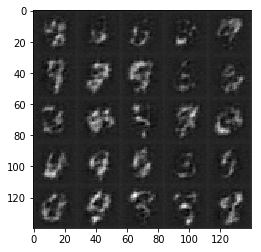

Epoch 1/2... Discriminator Loss: 0.2283... Generator Loss: 2.2017
Epoch 1/2... Discriminator Loss: 0.1557... Generator Loss: 2.7187
Epoch 1/2... Discriminator Loss: 0.1329... Generator Loss: 2.7719
Epoch 1/2... Discriminator Loss: 0.1728... Generator Loss: 2.5336
Epoch 1/2... Discriminator Loss: 0.0775... Generator Loss: 3.2273
Epoch 1/2... Discriminator Loss: 0.3020... Generator Loss: 1.9286
Epoch 1/2... Discriminator Loss: 0.0925... Generator Loss: 3.3114
Epoch 1/2... Discriminator Loss: 0.1569... Generator Loss: 2.4594
Epoch 1/2... Discriminator Loss: 0.0979... Generator Loss: 3.4950
Epoch 1/2... Discriminator Loss: 0.0805... Generator Loss: 3.3399


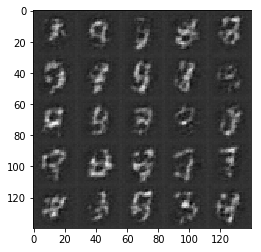

Epoch 1/2... Discriminator Loss: 0.0963... Generator Loss: 3.0121
Epoch 1/2... Discriminator Loss: 0.1267... Generator Loss: 2.7011
Epoch 1/2... Discriminator Loss: 0.4186... Generator Loss: 1.6534
Epoch 1/2... Discriminator Loss: 0.1520... Generator Loss: 2.7913
Epoch 1/2... Discriminator Loss: 0.1285... Generator Loss: 2.7236
Epoch 1/2... Discriminator Loss: 0.1130... Generator Loss: 2.7483
Epoch 1/2... Discriminator Loss: 0.1266... Generator Loss: 2.7862
Epoch 1/2... Discriminator Loss: 0.0739... Generator Loss: 3.2307
Epoch 1/2... Discriminator Loss: 0.1238... Generator Loss: 3.1206
Epoch 1/2... Discriminator Loss: 0.1488... Generator Loss: 2.9211


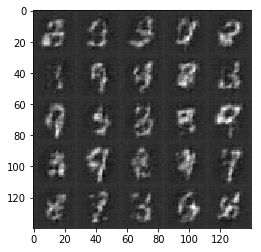

Epoch 1/2... Discriminator Loss: 2.1276... Generator Loss: 2.2663
Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 2.0373
Epoch 1/2... Discriminator Loss: 0.2426... Generator Loss: 2.3786
Epoch 1/2... Discriminator Loss: 0.2938... Generator Loss: 2.1297
Epoch 1/2... Discriminator Loss: 0.3333... Generator Loss: 2.0952
Epoch 1/2... Discriminator Loss: 0.3143... Generator Loss: 2.2833
Epoch 1/2... Discriminator Loss: 0.1731... Generator Loss: 2.8267
Epoch 1/2... Discriminator Loss: 0.2694... Generator Loss: 2.0627
Epoch 1/2... Discriminator Loss: 0.2570... Generator Loss: 2.4213
Epoch 1/2... Discriminator Loss: 0.2410... Generator Loss: 2.0337


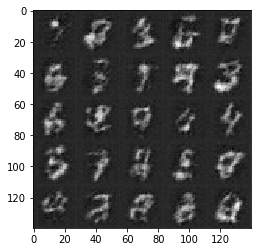

Epoch 1/2... Discriminator Loss: 0.1852... Generator Loss: 2.4466
Epoch 1/2... Discriminator Loss: 0.2343... Generator Loss: 2.0767
Epoch 1/2... Discriminator Loss: 0.3187... Generator Loss: 1.8198
Epoch 1/2... Discriminator Loss: 0.1959... Generator Loss: 2.1360
Epoch 1/2... Discriminator Loss: 0.1433... Generator Loss: 2.7595
Epoch 1/2... Discriminator Loss: 0.1677... Generator Loss: 2.5672
Epoch 1/2... Discriminator Loss: 0.1940... Generator Loss: 2.2927
Epoch 1/2... Discriminator Loss: 0.1505... Generator Loss: 2.7526
Epoch 1/2... Discriminator Loss: 0.1167... Generator Loss: 3.2526
Epoch 1/2... Discriminator Loss: 0.0878... Generator Loss: 3.1877


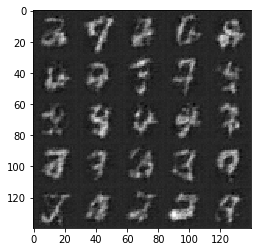

Epoch 1/2... Discriminator Loss: 0.2500... Generator Loss: 1.9320
Epoch 1/2... Discriminator Loss: 0.1571... Generator Loss: 2.6870
Epoch 1/2... Discriminator Loss: 0.0993... Generator Loss: 3.1564
Epoch 1/2... Discriminator Loss: 0.1569... Generator Loss: 3.1565
Epoch 1/2... Discriminator Loss: 0.0793... Generator Loss: 3.2436
Epoch 1/2... Discriminator Loss: 0.2217... Generator Loss: 2.2755
Epoch 1/2... Discriminator Loss: 0.1739... Generator Loss: 2.5465
Epoch 1/2... Discriminator Loss: 0.0864... Generator Loss: 3.3375
Epoch 1/2... Discriminator Loss: 0.2113... Generator Loss: 2.3701
Epoch 1/2... Discriminator Loss: 0.1281... Generator Loss: 2.7779


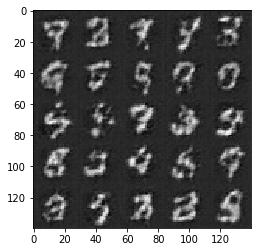

Epoch 1/2... Discriminator Loss: 0.2929... Generator Loss: 1.6917
Epoch 1/2... Discriminator Loss: 0.1694... Generator Loss: 2.3893
Epoch 1/2... Discriminator Loss: 0.2012... Generator Loss: 2.3344
Epoch 1/2... Discriminator Loss: 0.1914... Generator Loss: 2.3732
Epoch 1/2... Discriminator Loss: 0.1464... Generator Loss: 2.5027
Epoch 1/2... Discriminator Loss: 0.1825... Generator Loss: 2.4619
Epoch 1/2... Discriminator Loss: 0.2790... Generator Loss: 1.8002
Epoch 1/2... Discriminator Loss: 0.5740... Generator Loss: 1.5153
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 2.6514
Epoch 1/2... Discriminator Loss: 0.7456... Generator Loss: 2.3384


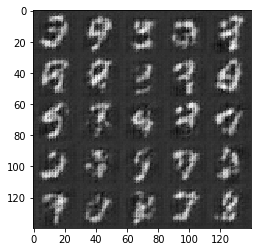

Epoch 1/2... Discriminator Loss: 0.7782... Generator Loss: 1.1771
Epoch 1/2... Discriminator Loss: 1.4517... Generator Loss: 0.3969
Epoch 1/2... Discriminator Loss: 0.3962... Generator Loss: 1.6151
Epoch 1/2... Discriminator Loss: 0.3635... Generator Loss: 1.7931
Epoch 1/2... Discriminator Loss: 0.6763... Generator Loss: 1.0405
Epoch 1/2... Discriminator Loss: 0.4609... Generator Loss: 1.4049
Epoch 1/2... Discriminator Loss: 0.2910... Generator Loss: 1.8744
Epoch 1/2... Discriminator Loss: 0.1923... Generator Loss: 2.5405
Epoch 1/2... Discriminator Loss: 0.2306... Generator Loss: 2.1299
Epoch 1/2... Discriminator Loss: 0.2564... Generator Loss: 2.1308


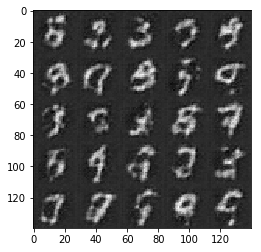

Epoch 1/2... Discriminator Loss: 0.2638... Generator Loss: 2.0880
Epoch 1/2... Discriminator Loss: 0.1782... Generator Loss: 2.3472
Epoch 1/2... Discriminator Loss: 0.5905... Generator Loss: 1.1290
Epoch 1/2... Discriminator Loss: 0.3092... Generator Loss: 1.7189
Epoch 1/2... Discriminator Loss: 0.2010... Generator Loss: 2.4000
Epoch 1/2... Discriminator Loss: 0.2853... Generator Loss: 1.7998
Epoch 1/2... Discriminator Loss: 0.1273... Generator Loss: 2.8957
Epoch 1/2... Discriminator Loss: 0.2449... Generator Loss: 1.9292
Epoch 1/2... Discriminator Loss: 0.1247... Generator Loss: 2.7960
Epoch 1/2... Discriminator Loss: 0.1659... Generator Loss: 2.4612


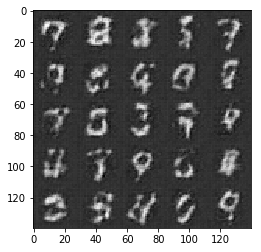

Epoch 1/2... Discriminator Loss: 0.1875... Generator Loss: 2.2940
Epoch 1/2... Discriminator Loss: 0.1977... Generator Loss: 2.1524
Epoch 1/2... Discriminator Loss: 0.2184... Generator Loss: 2.1012
Epoch 1/2... Discriminator Loss: 0.0807... Generator Loss: 3.5732
Epoch 1/2... Discriminator Loss: 0.1325... Generator Loss: 3.0510
Epoch 1/2... Discriminator Loss: 0.1212... Generator Loss: 3.0242
Epoch 1/2... Discriminator Loss: 0.1293... Generator Loss: 2.7207
Epoch 1/2... Discriminator Loss: 0.1709... Generator Loss: 2.5840
Epoch 1/2... Discriminator Loss: 0.2371... Generator Loss: 2.0526
Epoch 1/2... Discriminator Loss: 0.1607... Generator Loss: 2.6456


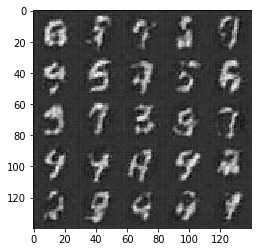

Epoch 1/2... Discriminator Loss: 0.1050... Generator Loss: 2.9664
Epoch 1/2... Discriminator Loss: 0.0517... Generator Loss: 4.0762
Epoch 1/2... Discriminator Loss: 0.1069... Generator Loss: 3.3916
Epoch 1/2... Discriminator Loss: 0.3196... Generator Loss: 1.5778
Epoch 1/2... Discriminator Loss: 0.2587... Generator Loss: 2.0675
Epoch 1/2... Discriminator Loss: 0.0749... Generator Loss: 3.4425
Epoch 1/2... Discriminator Loss: 0.0499... Generator Loss: 4.3901
Epoch 2/2... Discriminator Loss: 0.1816... Generator Loss: 2.3490
Epoch 2/2... Discriminator Loss: 0.2274... Generator Loss: 1.9565
Epoch 2/2... Discriminator Loss: 0.1576... Generator Loss: 2.5918


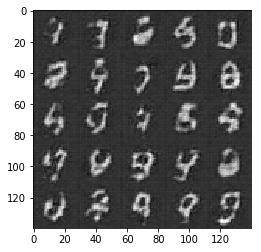

Epoch 2/2... Discriminator Loss: 0.3974... Generator Loss: 1.4613
Epoch 2/2... Discriminator Loss: 0.1944... Generator Loss: 2.3379
Epoch 2/2... Discriminator Loss: 0.1724... Generator Loss: 2.3906
Epoch 2/2... Discriminator Loss: 0.0747... Generator Loss: 3.9978
Epoch 2/2... Discriminator Loss: 0.1248... Generator Loss: 2.6274
Epoch 2/2... Discriminator Loss: 0.0236... Generator Loss: 6.0739
Epoch 2/2... Discriminator Loss: 0.3551... Generator Loss: 1.7303
Epoch 2/2... Discriminator Loss: 0.1661... Generator Loss: 2.4158
Epoch 2/2... Discriminator Loss: 0.0674... Generator Loss: 3.4610
Epoch 2/2... Discriminator Loss: 0.0786... Generator Loss: 4.2665


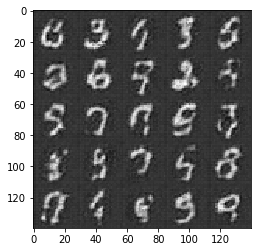

Epoch 2/2... Discriminator Loss: 0.1457... Generator Loss: 2.6251
Epoch 2/2... Discriminator Loss: 0.1768... Generator Loss: 2.3214
Epoch 2/2... Discriminator Loss: 0.0876... Generator Loss: 2.9964
Epoch 2/2... Discriminator Loss: 0.2160... Generator Loss: 2.0203
Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 2.8577
Epoch 2/2... Discriminator Loss: 1.0944... Generator Loss: 0.9190
Epoch 2/2... Discriminator Loss: 0.5490... Generator Loss: 2.1934
Epoch 2/2... Discriminator Loss: 0.8558... Generator Loss: 0.8520
Epoch 2/2... Discriminator Loss: 0.5739... Generator Loss: 1.2860
Epoch 2/2... Discriminator Loss: 0.4783... Generator Loss: 2.1314


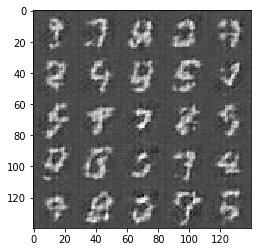

Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 4.2017
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 0.9022
Epoch 2/2... Discriminator Loss: 0.3862... Generator Loss: 2.2117
Epoch 2/2... Discriminator Loss: 0.2682... Generator Loss: 1.9347
Epoch 2/2... Discriminator Loss: 0.4074... Generator Loss: 2.1694
Epoch 2/2... Discriminator Loss: 0.3483... Generator Loss: 1.9329
Epoch 2/2... Discriminator Loss: 0.3229... Generator Loss: 3.0800
Epoch 2/2... Discriminator Loss: 0.2732... Generator Loss: 2.4579
Epoch 2/2... Discriminator Loss: 0.2708... Generator Loss: 2.7025
Epoch 2/2... Discriminator Loss: 0.2139... Generator Loss: 2.3991


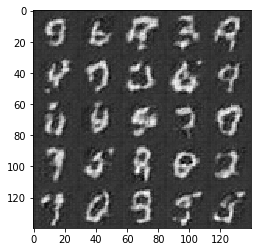

Epoch 2/2... Discriminator Loss: 0.2522... Generator Loss: 2.2681
Epoch 2/2... Discriminator Loss: 0.2167... Generator Loss: 2.2143
Epoch 2/2... Discriminator Loss: 0.2658... Generator Loss: 3.0873
Epoch 2/2... Discriminator Loss: 0.2898... Generator Loss: 1.7890
Epoch 2/2... Discriminator Loss: 0.2334... Generator Loss: 2.8434
Epoch 2/2... Discriminator Loss: 0.2437... Generator Loss: 1.8797
Epoch 2/2... Discriminator Loss: 0.2592... Generator Loss: 1.7366
Epoch 2/2... Discriminator Loss: 0.1456... Generator Loss: 2.6525
Epoch 2/2... Discriminator Loss: 0.2498... Generator Loss: 2.8415
Epoch 2/2... Discriminator Loss: 0.1968... Generator Loss: 2.3401


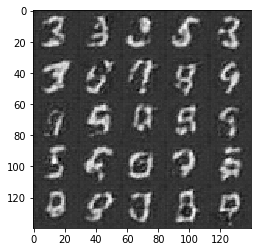

Epoch 2/2... Discriminator Loss: 0.1520... Generator Loss: 2.4976
Epoch 2/2... Discriminator Loss: 0.1655... Generator Loss: 2.5545
Epoch 2/2... Discriminator Loss: 0.2411... Generator Loss: 1.9513
Epoch 2/2... Discriminator Loss: 0.1283... Generator Loss: 2.7855
Epoch 2/2... Discriminator Loss: 0.1267... Generator Loss: 3.4083
Epoch 2/2... Discriminator Loss: 0.2199... Generator Loss: 1.9685
Epoch 2/2... Discriminator Loss: 0.2450... Generator Loss: 1.8841
Epoch 2/2... Discriminator Loss: 0.2174... Generator Loss: 2.3063
Epoch 2/2... Discriminator Loss: 0.1355... Generator Loss: 2.5655
Epoch 2/2... Discriminator Loss: 0.1786... Generator Loss: 2.4374


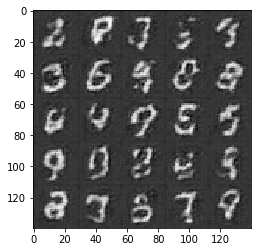

Epoch 2/2... Discriminator Loss: 0.1758... Generator Loss: 3.3905
Epoch 2/2... Discriminator Loss: 0.5723... Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 0.2962... Generator Loss: 1.8460
Epoch 2/2... Discriminator Loss: 0.1341... Generator Loss: 2.9354
Epoch 2/2... Discriminator Loss: 0.1659... Generator Loss: 2.4991
Epoch 2/2... Discriminator Loss: 0.1353... Generator Loss: 2.5356
Epoch 2/2... Discriminator Loss: 0.0988... Generator Loss: 3.5855
Epoch 2/2... Discriminator Loss: 0.2912... Generator Loss: 1.7248
Epoch 2/2... Discriminator Loss: 0.3514... Generator Loss: 1.9862
Epoch 2/2... Discriminator Loss: 0.0547... Generator Loss: 3.7924


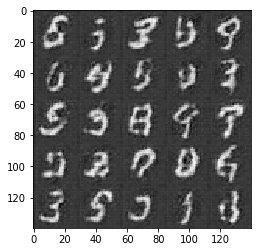

Epoch 2/2... Discriminator Loss: 0.1452... Generator Loss: 2.7827
Epoch 2/2... Discriminator Loss: 0.0864... Generator Loss: 3.2075
Epoch 2/2... Discriminator Loss: 0.1885... Generator Loss: 2.4133
Epoch 2/2... Discriminator Loss: 0.1476... Generator Loss: 2.8074
Epoch 2/2... Discriminator Loss: 0.1502... Generator Loss: 2.6104
Epoch 2/2... Discriminator Loss: 0.1059... Generator Loss: 3.3110
Epoch 2/2... Discriminator Loss: 0.0967... Generator Loss: 3.2917
Epoch 2/2... Discriminator Loss: 0.1050... Generator Loss: 3.0616
Epoch 2/2... Discriminator Loss: 0.2058... Generator Loss: 2.0606
Epoch 2/2... Discriminator Loss: 0.0548... Generator Loss: 3.3233


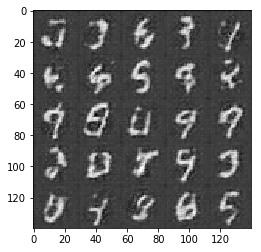

Epoch 2/2... Discriminator Loss: 0.7390... Generator Loss: 0.9714
Epoch 2/2... Discriminator Loss: 0.1257... Generator Loss: 2.6274
Epoch 2/2... Discriminator Loss: 0.6518... Generator Loss: 0.9884
Epoch 2/2... Discriminator Loss: 1.7677... Generator Loss: 5.5001
Epoch 2/2... Discriminator Loss: 0.2605... Generator Loss: 4.8676
Epoch 2/2... Discriminator Loss: 0.2706... Generator Loss: 2.2078
Epoch 2/2... Discriminator Loss: 0.3938... Generator Loss: 1.4171
Epoch 2/2... Discriminator Loss: 0.2532... Generator Loss: 2.3809
Epoch 2/2... Discriminator Loss: 0.4617... Generator Loss: 1.2994
Epoch 2/2... Discriminator Loss: 0.1972... Generator Loss: 2.4405


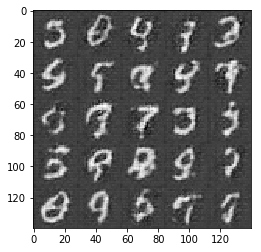

Epoch 2/2... Discriminator Loss: 0.2144... Generator Loss: 2.3214
Epoch 2/2... Discriminator Loss: 0.2053... Generator Loss: 2.2571
Epoch 2/2... Discriminator Loss: 0.0831... Generator Loss: 3.4518
Epoch 2/2... Discriminator Loss: 0.1964... Generator Loss: 2.2733
Epoch 2/2... Discriminator Loss: 0.1858... Generator Loss: 2.2147
Epoch 2/2... Discriminator Loss: 0.3960... Generator Loss: 1.5133
Epoch 2/2... Discriminator Loss: 0.3443... Generator Loss: 1.5209
Epoch 2/2... Discriminator Loss: 0.1389... Generator Loss: 2.6479
Epoch 2/2... Discriminator Loss: 0.1310... Generator Loss: 3.0450
Epoch 2/2... Discriminator Loss: 0.1406... Generator Loss: 2.9344


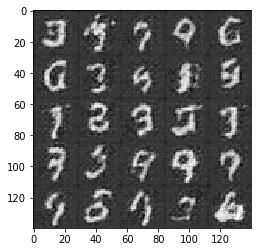

Epoch 2/2... Discriminator Loss: 0.2259... Generator Loss: 2.2731
Epoch 2/2... Discriminator Loss: 0.1385... Generator Loss: 2.5423
Epoch 2/2... Discriminator Loss: 0.1913... Generator Loss: 2.0570
Epoch 2/2... Discriminator Loss: 0.1113... Generator Loss: 2.9835
Epoch 2/2... Discriminator Loss: 0.0728... Generator Loss: 4.2321
Epoch 2/2... Discriminator Loss: 0.3553... Generator Loss: 1.7397
Epoch 2/2... Discriminator Loss: 0.1210... Generator Loss: 2.6735
Epoch 2/2... Discriminator Loss: 0.2666... Generator Loss: 1.8689
Epoch 2/2... Discriminator Loss: 0.2541... Generator Loss: 1.9173
Epoch 2/2... Discriminator Loss: 0.1093... Generator Loss: 3.0861


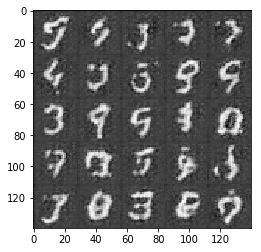

Epoch 2/2... Discriminator Loss: 0.1359... Generator Loss: 2.6884
Epoch 2/2... Discriminator Loss: 0.0781... Generator Loss: 3.1959
Epoch 2/2... Discriminator Loss: 0.1083... Generator Loss: 2.9653
Epoch 2/2... Discriminator Loss: 0.0701... Generator Loss: 3.2457
Epoch 2/2... Discriminator Loss: 0.1439... Generator Loss: 2.6422
Epoch 2/2... Discriminator Loss: 0.0759... Generator Loss: 4.0152
Epoch 2/2... Discriminator Loss: 0.3461... Generator Loss: 1.6378
Epoch 2/2... Discriminator Loss: 0.1201... Generator Loss: 3.0563
Epoch 2/2... Discriminator Loss: 0.3405... Generator Loss: 1.6184
Epoch 2/2... Discriminator Loss: 0.1683... Generator Loss: 2.6189


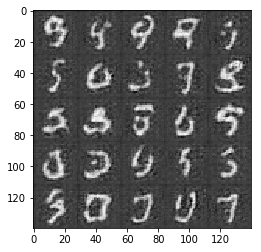

Epoch 2/2... Discriminator Loss: 0.1744... Generator Loss: 2.9340
Epoch 2/2... Discriminator Loss: 0.1030... Generator Loss: 2.8432
Epoch 2/2... Discriminator Loss: 0.0415... Generator Loss: 3.9050
Epoch 2/2... Discriminator Loss: 0.0547... Generator Loss: 3.4199
Epoch 2/2... Discriminator Loss: 0.1081... Generator Loss: 3.1719
Epoch 2/2... Discriminator Loss: 0.2128... Generator Loss: 2.0788
Epoch 2/2... Discriminator Loss: 0.0838... Generator Loss: 2.9051
Epoch 2/2... Discriminator Loss: 0.0405... Generator Loss: 3.9062
Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 1.2091
Epoch 2/2... Discriminator Loss: 0.6228... Generator Loss: 2.4770


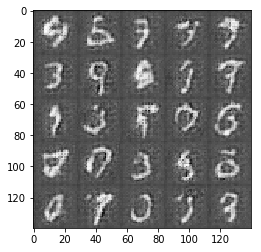

Epoch 2/2... Discriminator Loss: 0.3942... Generator Loss: 3.9788
Epoch 2/2... Discriminator Loss: 0.4183... Generator Loss: 1.4871
Epoch 2/2... Discriminator Loss: 0.3769... Generator Loss: 1.6762
Epoch 2/2... Discriminator Loss: 0.2216... Generator Loss: 2.3266
Epoch 2/2... Discriminator Loss: 0.2087... Generator Loss: 2.4145
Epoch 2/2... Discriminator Loss: 0.1685... Generator Loss: 2.8163
Epoch 2/2... Discriminator Loss: 0.2667... Generator Loss: 2.0416
Epoch 2/2... Discriminator Loss: 0.1466... Generator Loss: 2.8313
Epoch 2/2... Discriminator Loss: 0.2396... Generator Loss: 2.2635
Epoch 2/2... Discriminator Loss: 0.2428... Generator Loss: 1.9541


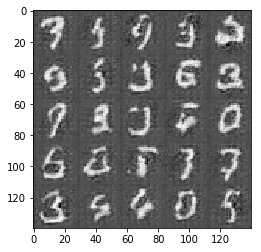

Epoch 2/2... Discriminator Loss: 0.1643... Generator Loss: 2.7367
Epoch 2/2... Discriminator Loss: 0.2610... Generator Loss: 1.8414
Epoch 2/2... Discriminator Loss: 0.1869... Generator Loss: 2.3085
Epoch 2/2... Discriminator Loss: 0.1528... Generator Loss: 3.7140
Epoch 2/2... Discriminator Loss: 0.1467... Generator Loss: 3.6868
Epoch 2/2... Discriminator Loss: 0.6138... Generator Loss: 1.0205
Epoch 2/2... Discriminator Loss: 0.1489... Generator Loss: 2.3668
Epoch 2/2... Discriminator Loss: 0.1002... Generator Loss: 3.0262
Epoch 2/2... Discriminator Loss: 0.0856... Generator Loss: 3.3190
Epoch 2/2... Discriminator Loss: 0.1733... Generator Loss: 2.3292


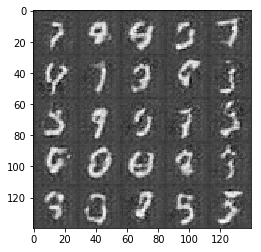

Epoch 2/2... Discriminator Loss: 0.2500... Generator Loss: 2.1034
Epoch 2/2... Discriminator Loss: 0.2672... Generator Loss: 2.0549
Epoch 2/2... Discriminator Loss: 0.1899... Generator Loss: 2.5210
Epoch 2/2... Discriminator Loss: 0.0558... Generator Loss: 3.7366
Epoch 2/2... Discriminator Loss: 0.1263... Generator Loss: 2.8295
Epoch 2/2... Discriminator Loss: 0.1225... Generator Loss: 2.6221
Epoch 2/2... Discriminator Loss: 0.2805... Generator Loss: 1.6884
Epoch 2/2... Discriminator Loss: 0.2354... Generator Loss: 2.1577
Epoch 2/2... Discriminator Loss: 0.2460... Generator Loss: 2.0474
Epoch 2/2... Discriminator Loss: 0.1589... Generator Loss: 2.3956


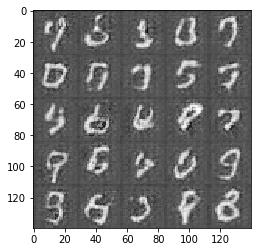

Epoch 2/2... Discriminator Loss: 0.1963... Generator Loss: 2.4652
Epoch 2/2... Discriminator Loss: 0.2013... Generator Loss: 2.3316
Epoch 2/2... Discriminator Loss: 0.2042... Generator Loss: 2.1715
Epoch 2/2... Discriminator Loss: 0.1093... Generator Loss: 4.3985
Epoch 2/2... Discriminator Loss: 0.9508... Generator Loss: 4.8287
Epoch 2/2... Discriminator Loss: 0.6325... Generator Loss: 1.1018
Epoch 2/2... Discriminator Loss: 0.5877... Generator Loss: 3.4648
Epoch 2/2... Discriminator Loss: 0.3930... Generator Loss: 1.7857
Epoch 2/2... Discriminator Loss: 0.8212... Generator Loss: 4.0715
Epoch 2/2... Discriminator Loss: 0.2413... Generator Loss: 2.3776


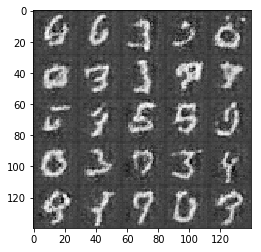

Epoch 2/2... Discriminator Loss: 0.4839... Generator Loss: 1.2713
Epoch 2/2... Discriminator Loss: 0.2926... Generator Loss: 2.1191
Epoch 2/2... Discriminator Loss: 0.4314... Generator Loss: 1.3841
Epoch 2/2... Discriminator Loss: 0.3788... Generator Loss: 1.8167
Epoch 2/2... Discriminator Loss: 0.2565... Generator Loss: 2.2954
Epoch 2/2... Discriminator Loss: 0.1692... Generator Loss: 2.6035
Epoch 2/2... Discriminator Loss: 0.2775... Generator Loss: 3.3958
Epoch 2/2... Discriminator Loss: 0.1059... Generator Loss: 2.8758
Epoch 2/2... Discriminator Loss: 0.3623... Generator Loss: 1.6113
Epoch 2/2... Discriminator Loss: 0.3966... Generator Loss: 1.4209


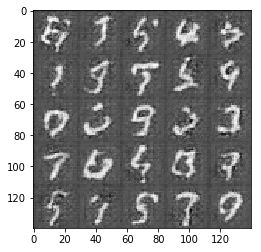

Epoch 2/2... Discriminator Loss: 0.1653... Generator Loss: 2.6257
Epoch 2/2... Discriminator Loss: 0.2339... Generator Loss: 2.6873
Epoch 2/2... Discriminator Loss: 0.1139... Generator Loss: 3.1485
Epoch 2/2... Discriminator Loss: 0.1972... Generator Loss: 2.8766
Epoch 2/2... Discriminator Loss: 0.1519... Generator Loss: 3.4746
Epoch 2/2... Discriminator Loss: 0.1822... Generator Loss: 2.5724
Epoch 2/2... Discriminator Loss: 0.1856... Generator Loss: 2.3676
Epoch 2/2... Discriminator Loss: 0.1709... Generator Loss: 2.4613
Epoch 2/2... Discriminator Loss: 0.1097... Generator Loss: 3.1048
Epoch 2/2... Discriminator Loss: 0.1701... Generator Loss: 2.3535


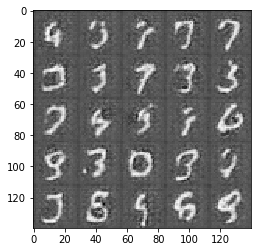

Epoch 2/2... Discriminator Loss: 0.1065... Generator Loss: 3.2307
Epoch 2/2... Discriminator Loss: 0.2016... Generator Loss: 2.3275
Epoch 2/2... Discriminator Loss: 0.1418... Generator Loss: 2.8462
Epoch 2/2... Discriminator Loss: 0.2586... Generator Loss: 2.0337
Epoch 2/2... Discriminator Loss: 0.3471... Generator Loss: 1.7383


In [240]:
batch_size = 32
z_dim = 100
learning_rate = 0.0007
beta1 = 0.5 # for the Adam Optimizer

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
    

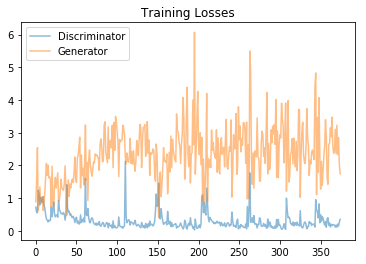

In [241]:
import matplotlib.pylab as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

#### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 2.3821
Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 1.9528
Epoch 1/1... Discriminator Loss: 0.2631... Generator Loss: 3.0818
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 2.2882
Epoch 1/1... Discriminator Loss: 0.1042... Generator Loss: 3.5476
Epoch 1/1... Discriminator Loss: 0.0830... Generator Loss: 4.4195
Epoch 1/1... Discriminator Loss: 0.0917... Generator Loss: 3.7769
Epoch 1/1... Discriminator Loss: 0.0841... Generator Loss: 3.7382
Epoch 1/1... Discriminator Loss: 0.1457... Generator Loss: 2.9662


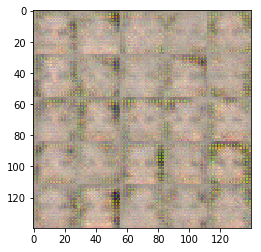

Epoch 1/1... Discriminator Loss: 0.0651... Generator Loss: 3.8022
Epoch 1/1... Discriminator Loss: 0.0895... Generator Loss: 3.5515
Epoch 1/1... Discriminator Loss: 0.0318... Generator Loss: 4.5085
Epoch 1/1... Discriminator Loss: 0.0287... Generator Loss: 4.3107
Epoch 1/1... Discriminator Loss: 0.0396... Generator Loss: 4.0836
Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 4.7009
Epoch 1/1... Discriminator Loss: 0.0425... Generator Loss: 3.9756
Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 5.9374
Epoch 1/1... Discriminator Loss: 0.0391... Generator Loss: 3.5892
Epoch 1/1... Discriminator Loss: 0.3012... Generator Loss: 9.8850


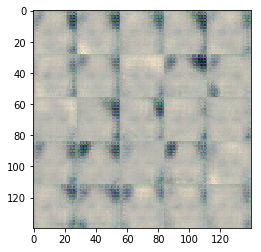

Epoch 1/1... Discriminator Loss: 0.0362... Generator Loss: 5.2929
Epoch 1/1... Discriminator Loss: 0.0407... Generator Loss: 5.4935
Epoch 1/1... Discriminator Loss: 0.2929... Generator Loss: 2.4011
Epoch 1/1... Discriminator Loss: 0.0719... Generator Loss: 3.7598
Epoch 1/1... Discriminator Loss: 0.1313... Generator Loss: 3.1862
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 1.5368
Epoch 1/1... Discriminator Loss: 0.3741... Generator Loss: 1.7030
Epoch 1/1... Discriminator Loss: 0.2518... Generator Loss: 3.9262
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 1.9528
Epoch 1/1... Discriminator Loss: 0.4401... Generator Loss: 4.0859


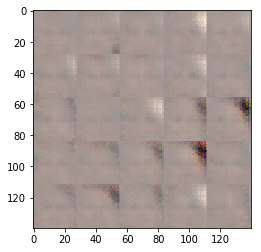

Epoch 1/1... Discriminator Loss: 0.7304... Generator Loss: 1.3793
Epoch 1/1... Discriminator Loss: 0.7289... Generator Loss: 1.2514
Epoch 1/1... Discriminator Loss: 0.4528... Generator Loss: 2.5790
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.8923
Epoch 1/1... Discriminator Loss: 0.4531... Generator Loss: 2.4257
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 0.2830... Generator Loss: 3.2114
Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 2.0721
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 1.6218


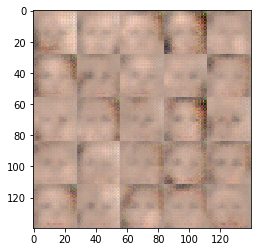

Epoch 1/1... Discriminator Loss: 0.4572... Generator Loss: 2.9196
Epoch 1/1... Discriminator Loss: 0.7129... Generator Loss: 1.4952
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 2.0646
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 1.5090
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 2.3298
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 1.8695
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 1.8472


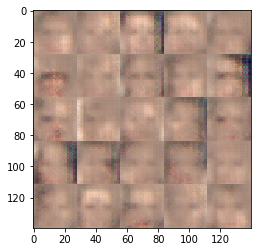

Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 3.2253
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 2.4787
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 2.8467
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.1499
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.7150


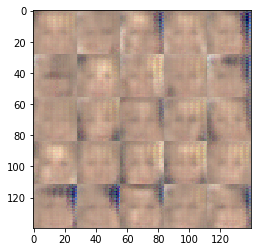

Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 3.3088
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.5700
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.9875
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.4974
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.6771... Generator Loss: 2.0252
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 1.1841
Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 2.3330
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 2.9563


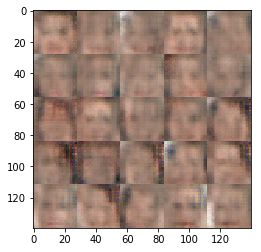

Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.2213
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 0.6724... Generator Loss: 1.7406
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 1.1582
Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 1.6911


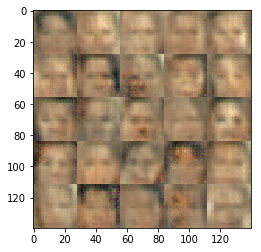

Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 2.3100
Epoch 1/1... Discriminator Loss: 0.4101... Generator Loss: 1.7377
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 0.5365... Generator Loss: 3.6711
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 0.6728... Generator Loss: 2.6290
Epoch 1/1... Discriminator Loss: 1.5962... Generator Loss: 0.4675


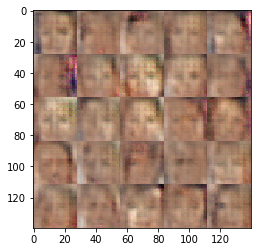

Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.3007
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 1.0807
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 1.2021
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 1.2052
Epoch 1/1... Discriminator Loss: 1.6295... Generator Loss: 1.3127
Epoch 1/1... Discriminator Loss: 1.6808... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 1.1619
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.7980


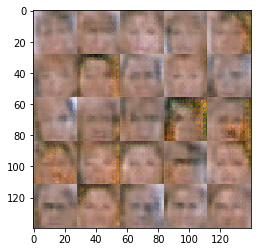

Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.6646
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.8443... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.7758... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.9440... Generator Loss: 1.1102
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 1.4892
Epoch 1/1... Discriminator Loss: 2.2990... Generator Loss: 0.3638


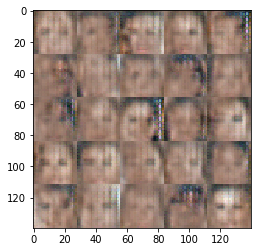

Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 1.9055
Epoch 1/1... Discriminator Loss: 1.6829... Generator Loss: 0.4133
Epoch 1/1... Discriminator Loss: 1.8606... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 3.7369
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 1.6054
Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 1.8349
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 1.3549
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.5835


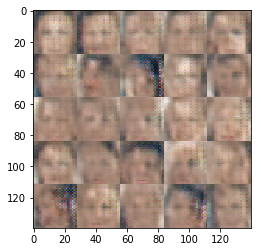

Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.3558
Epoch 1/1... Discriminator Loss: 0.7557... Generator Loss: 1.5763
Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 2.2983
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 1.7017
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.6481... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 1.2178


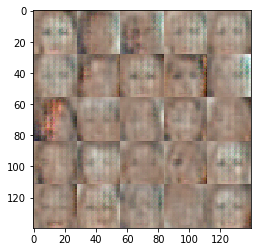

Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 1.8480
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 1.3036
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 2.1526... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 1.3430
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.7800
Epoch 1/1... Discriminator Loss: 2.4294... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.3698


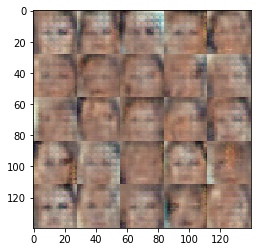

Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 0.6436... Generator Loss: 1.3217
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.9702... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.6341
Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 2.0013
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 2.0111... Generator Loss: 0.7271


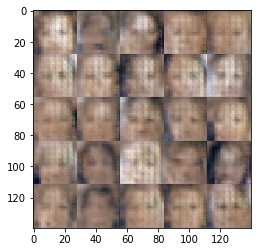

Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 2.5786... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.8930
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 2.0419
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 1.9489
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.3105
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 1.5860
Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.4814
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 0.9220


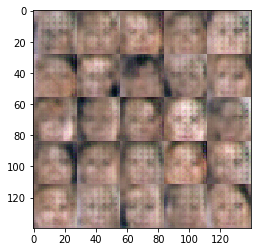

Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 2.3339
Epoch 1/1... Discriminator Loss: 2.2581... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.2435
Epoch 1/1... Discriminator Loss: 1.9487... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 1.2035
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 1.0191


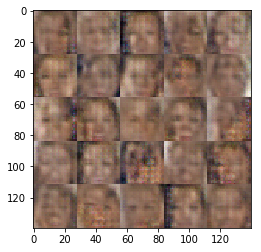

Epoch 1/1... Discriminator Loss: 1.8225... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.1291
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 2.1504... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 0.7839


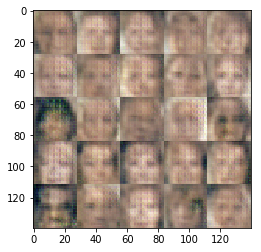

Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 1.8028... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.5980


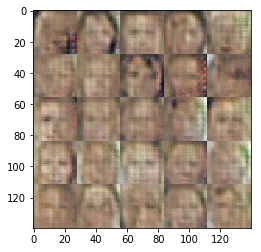

Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.9606
Epoch 1/1... Discriminator Loss: 1.6639... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 1.6812
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 0.7679... Generator Loss: 1.8223
Epoch 1/1... Discriminator Loss: 1.6066... Generator Loss: 0.8821


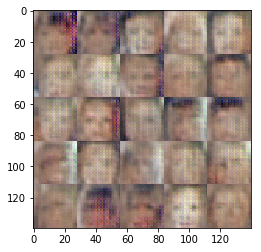

Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 1.7659
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.7878... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 1.3139
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.8536... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 0.6688... Generator Loss: 1.3722
Epoch 1/1... Discriminator Loss: 0.7553... Generator Loss: 1.7405
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.1905


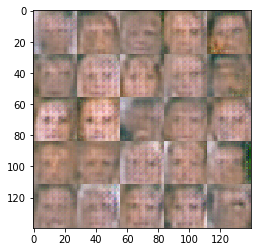

Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 1.6541
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 2.1071... Generator Loss: 0.4542
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 1.8401
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.9709... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 1.3377


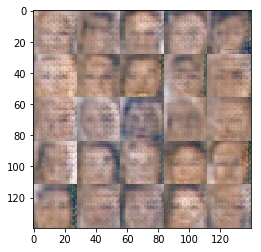

Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 1.6134
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 1.0033
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 1.8817
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.5190
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 1.3680
Epoch 1/1... Discriminator Loss: 1.8011... Generator Loss: 0.6610


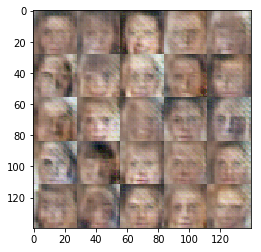

Epoch 1/1... Discriminator Loss: 2.0814... Generator Loss: 0.3026
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.4335
Epoch 1/1... Discriminator Loss: 1.6813... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 1.6883
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 1.3846
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.2008
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 1.0670


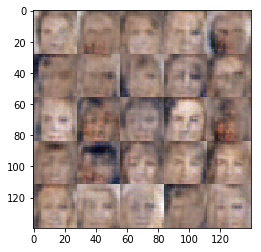

Epoch 1/1... Discriminator Loss: 0.5323... Generator Loss: 2.1174
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.7323
Epoch 1/1... Discriminator Loss: 1.6221... Generator Loss: 1.5522
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.7801
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 0.9412


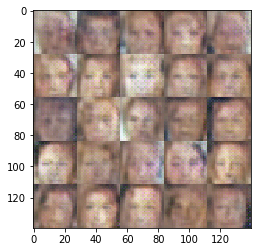

Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.5286
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 1.1801
Epoch 1/1... Discriminator Loss: 1.6175... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 1.2146
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.3131


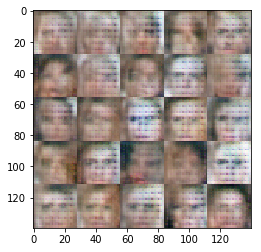

Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 1.1107
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 1.1762
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.9002
Epoch 1/1... Discriminator Loss: 2.0011... Generator Loss: 0.4381
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 1.0896
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 1.1145


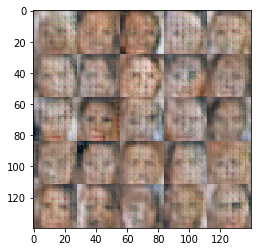

Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.4004
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.8769... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 1.6581
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 1.4109


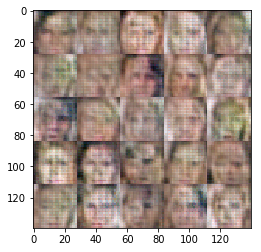

Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 1.5472
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 1.1432
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 1.0354
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 2.1170... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 1.6760
Epoch 1/1... Discriminator Loss: 1.7760... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 1.5075


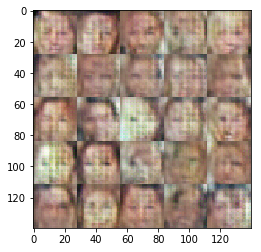

Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 1.7398... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 1.4225
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7172


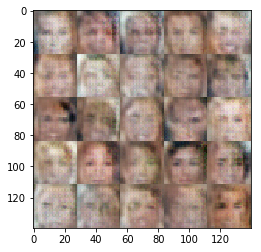

Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.7292... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.0556


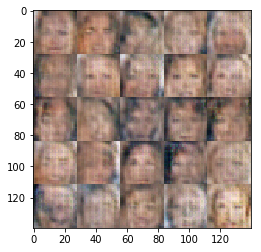

Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.7400... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 0.7356... Generator Loss: 1.1711
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.7736... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.9497


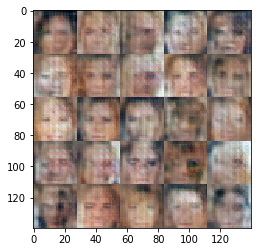

Epoch 1/1... Discriminator Loss: 1.6005... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 1.4825
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.5024
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 1.0098


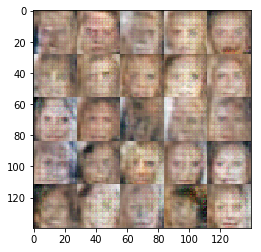

Epoch 1/1... Discriminator Loss: 2.1730... Generator Loss: 0.4220
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.4375
Epoch 1/1... Discriminator Loss: 2.0052... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.7709... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.2371
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 1.2706


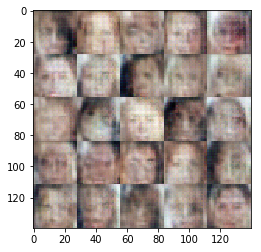

Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.1916
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.5602... Generator Loss: 0.5489
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 1.0103


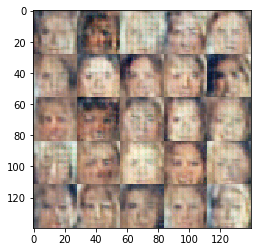

Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.8758... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.7976... Generator Loss: 0.6851


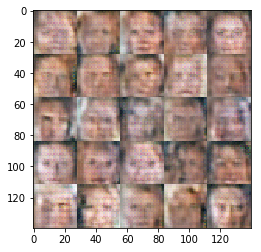

Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 1.0886
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 1.6242... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6497


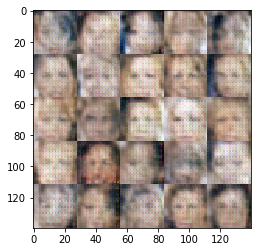

Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 1.7060


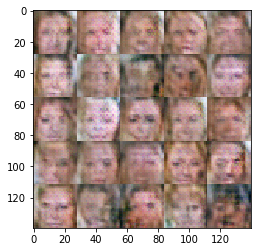

Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 1.0450
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.1786
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.0907
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 1.7624... Generator Loss: 0.7329


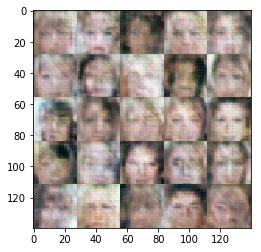

Epoch 1/1... Discriminator Loss: 1.8058... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.8740... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.8223... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 2.2677... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 3.0654... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.9168


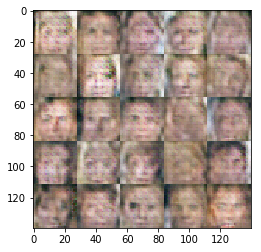

Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.8109... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 2.1960... Generator Loss: 0.5035
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.2641


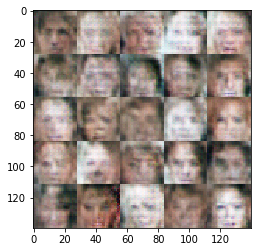

Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.7757... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.6093... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 1.2043
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.5614
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.6655
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 1.0755


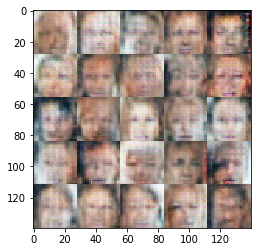

Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.7008... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.2040


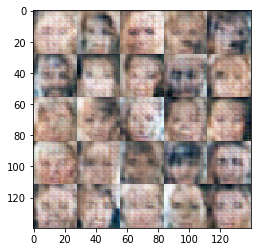

Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.1911
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.6241... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 1.1443
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7607


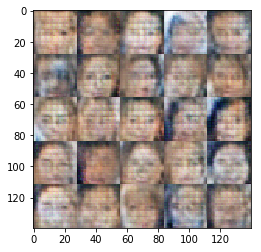

Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 2.1884... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.9954... Generator Loss: 0.8292


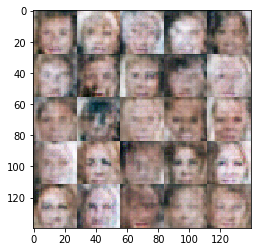

Epoch 1/1... Discriminator Loss: 1.5639... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.1915
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 1.0983
Epoch 1/1... Discriminator Loss: 1.7727... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.1603
Epoch 1/1... Discriminator Loss: 1.6663... Generator Loss: 0.8879


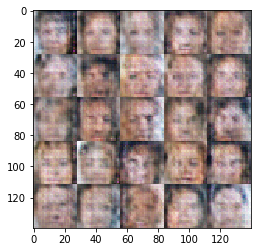

Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 0.8551... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.8039


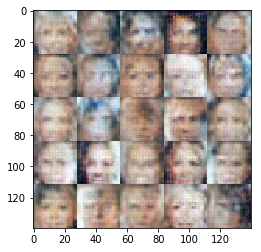

Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 1.1506
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 1.8085
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 1.7172... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 1.6701... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 0.5998... Generator Loss: 1.5328
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 1.0074


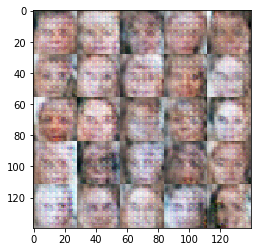

Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 1.0063
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.2870
Epoch 1/1... Discriminator Loss: 2.0082... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.7240... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 1.0202


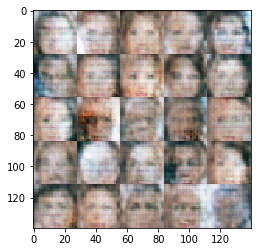

Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.1426
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 1.3454
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.2795


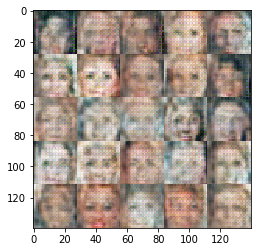

Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 1.2527
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 1.1781
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.0159


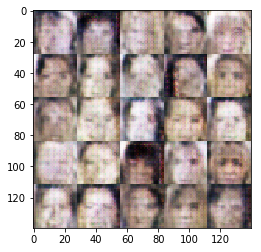

Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.3132
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.1918
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 1.0828
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 1.0829


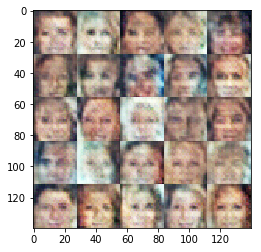

Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.9967... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.7014... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 1.2981
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 2.0386... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 0.9706


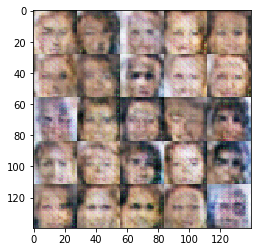

Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 0.6648... Generator Loss: 1.4615
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 1.6328... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.8357... Generator Loss: 0.4401
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.2976
Epoch 1/1... Discriminator Loss: 1.8393... Generator Loss: 0.4519


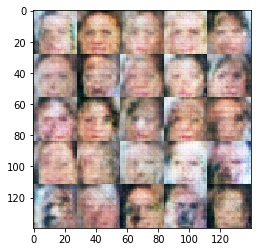

Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.1816
Epoch 1/1... Discriminator Loss: 1.5810... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.9406


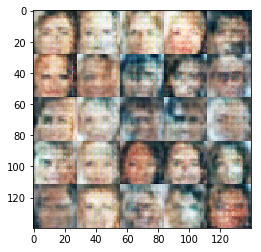

Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 0.9370... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 0.7163


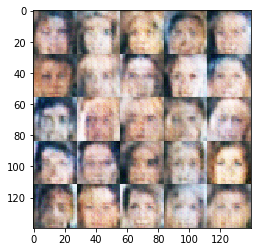

Epoch 1/1... Discriminator Loss: 1.6389... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.3655
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.1041
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 1.3538


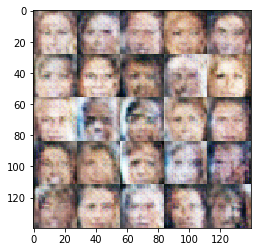

Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.6355
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.5914... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.7329... Generator Loss: 0.7522


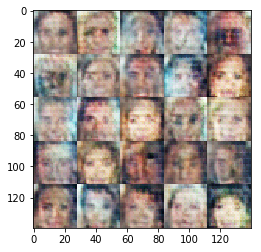

Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.4172
Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 1.1744


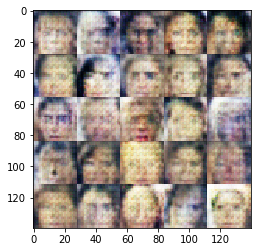

Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 1.1833
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.8798... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.5251
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.2747
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.0615


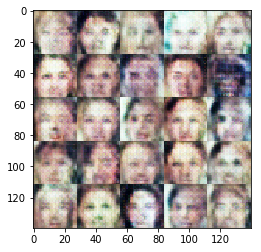

Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.6435... Generator Loss: 0.4371
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 1.3536


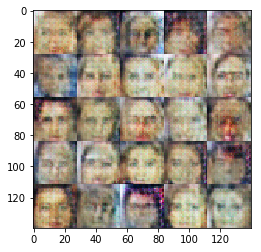

Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 1.1041
Epoch 1/1... Discriminator Loss: 1.5922... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.7796... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.2988
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.4011


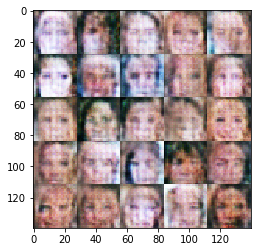

Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.1806
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.3860
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.5697


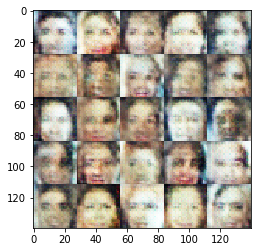

Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 1.3048


In [248]:
batch_size = 32
z_dim = 100
learning_rate = 0.0007
beta1 = 0.8 # for the Adam Optimizer

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

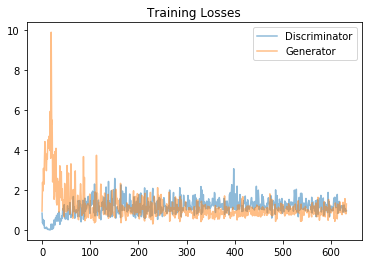

In [249]:
import matplotlib.pylab as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.